In [1]:
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=110,
    target_version=black.TargetVersion.PY310,
)

In [2]:
import datetime
import math
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from matplotlib.animation import FFMpegWriter, FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap

import lysis

pd.reset_option("display.precision")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

In [3]:
scenario_type = np.dtype(
    [
        ("descriptor", np.str_, 40),
        ("total_molecules", int),
        ("pore_size", float),  # in microns. Code requires cm
        ("fiber_diameter", float),  # in nanometers. Needs to be added to pore_size to get grid_node_distance
        ("cols", int),
        ("rows", int),
        ("forced_unbind", float),
    ]
)
mechanism_type = np.dtype([("descriptor", np.str_, 40), ("executable", np.str_, 40)])
run_type = np.dtype(
    [
        ("exp_code", np.str_, 15),
        ("scenario", np.str_, 40),
        ("mechanism", np.str_, 40),
        ("seed", int),
        ("running_time", int),
    ]
)
diameter_code = {
    72.7: "Q2",
    145.4: "Q4",
}

In [4]:
# seed sequence entropy: 3881821051554698152964433817123076384
scenarios = np.array(
    [
        ("TN-L_9350", 9_350, 1.0135, 72.7, 93, 121, 0.0852),
        ("TN-L_307", 307, 1.0135, 72.7, 93, 121, 0.0852),
        ("TN-D_684", 684, 0.22, 72.7, 342, 144, 0.0852),
        ("TN-D_9350", 9_350, 0.22, 72.7, 342, 144, 0.0852),
        ("TN-D_307", 307, 0.22, 72.7, 342, 144, 0.0852),
        ("TK-L_3042", 3_042, 1.0135, 145.4, 87, 67, 0.0729129),
        ("TK-L_9350", 9_350, 1.0135, 145.4, 87, 67, 0.0729129),
        ("TK-L_307", 307, 1.0135, 145.4, 87, 67, 0.0729129),
        ("TK-D_307", 307, 0.22, 145.4, 274, 65, 0.0729129),
        ("TK-D_9350", 9350, 0.22, 145.4, 274, 65, 0.0729129),
    ],
    dtype=scenario_type,
)
mechanisms = np.array(
    [
        ("Into and along - Internal", "macro_diffuse_into_and_along__internal"),
    ],
    dtype=mechanism_type,
)

In [5]:
in_file_code = "_PLG2_tPA01_{input_code}.dat"
out_file_code = "_{scenario_code}"

# slope_tolerance = 1e-3
rng = np.random.default_rng(65463453)

In [6]:
group_code = "2023-04-23-20"
runs = np.array(
    [
        (group_code + "00", "TN-L_9350", "Into and along - Internal", 1_034_836_197, 0),
        (group_code + "01", "TN-L_307", "Into and along - Internal", 2_464_079_704, 0),
        (group_code + "02", "TN-D_684", "Into and along - Internal", 982_919_027, 0),
        (group_code + "03", "TN-D_9350", "Into and along - Internal", 129_314_213, 0),
        (group_code + "04", "TN-D_307", "Into and along - Internal", 2_705_873_059, 0),
        (group_code + "05", "TK-L_3042", "Into and along - Internal", 2_104_158_012, 0),
        (group_code + "06", "TK-L_9350", "Into and along - Internal", 2_608_028_918, 0),
        (group_code + "07", "TK-L_307", "Into and along - Internal", 1_819_293_232, 0),
        (group_code + "08", "TK-D_307", "Into and along - Internal", 3_128_495_922, 0),
        (group_code + "09", "TK-D_9350", "Into and along - Internal", 106_672_317, 0),
    ],
    dtype=run_type,
)

In [7]:
index = pd.Index(runs["scenario"], name="Scenario")
degrade_percent_markers = [0.05, 0.2, 0.5, 0.8]
columns = pd.MultiIndex.from_product(
    [[f"{int(i*100)}%" for i in degrade_percent_markers], range(10)], names=["Percent Degraded", "Simulation"]
)
degradation_time_df = pd.DataFrame(index=index, columns=columns)

degrade_slope_between_percent = [[0.2, 0.8], [0.2, 0.5], [0.5, 0.8]]
columns = pd.MultiIndex.from_product(
    [[f"{int(i[0]*100)}% to {int(i[1]*100)}%" for i in degrade_slope_between_percent], range(10)],
    names=["Degradation Interval", "Simulation"],
)
slopes_df = pd.DataFrame(index=index, columns=columns)

In [8]:
# For a light colormap of degraded fibers
colormap_f = plt.cm.cividis(np.arange(plt.cm.cividis.N))
colormap_f[:, 3] = 0.3
# For very light grey degraded fibers
colormap_f = ["xkcd:light grey"]

colormap_f = ListedColormap(colormap_f)
colormap_f.set_extremes(bad="xkcd:blue", under="white", over="xkcd:blue")
colormap_m = ListedColormap(["xkcd:green", "xkcd:cyan"])
bounds = [0, 0.5, 1]
norm_m = BoundaryNorm(bounds, colormap_m.N)

angle = (1 / 2 - 1 / 8) * math.pi
radius = 0.5

In [9]:
def load_fortran_files(exp, file_code):
    n_save = np.asarray(
        [
            np.fromfile(
                os.path.join(e.os_path, f"{sim:02}", f"Nsave{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
                dtype=np.int32,
            )[0]
            for sim in range(e.macro_params.total_trials)
        ]
    )
    n_save += 1
    n_save

    tsave = [
        np.fromfile(os.path.join(e.os_path, f"{sim:02}", f"tsave{file_code[:-4]}_{sim:02}{file_code[-4:]}"))
        for sim in range(e.macro_params.total_trials)
    ]
    tmax = max([np.max(arr) for arr in tsave])

    mfpt = np.asarray(
        [
            np.fromfile(
                os.path.join(e.os_path, f"{sim:02}", f"mfpt{file_code[:-4]}_{sim:02}{file_code[-4:]}")
            )
            for sim in range(e.macro_params.total_trials)
        ]
    )

    mol_location = []
    mol_status = []
    mapped_deg = []
    for sim in range(e.macro_params.total_trials):
        raw_mol_location = np.fromfile(
            os.path.join(e.os_path, f"{sim:02}", f"m_loc{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
            dtype=np.int32,
        )
        mol_location.append(raw_mol_location.reshape(n_save[sim], e.macro_params.total_molecules) - 1)

        raw_mol_status = np.fromfile(
            os.path.join(e.os_path, f"{sim:02}", f"m_bound{file_code[:-4]}_{sim:02}{file_code[-4:]}"),
            dtype=np.int32,
        )
        raw_mol_status = raw_mol_status.astype(np.bool_)
        mol_status.append(raw_mol_status.reshape(n_save[sim], e.macro_params.total_molecules))

        raw_deg = np.fromfile(
            os.path.join(e.os_path, f"{sim:02}", f"f_deg_time{file_code[:-4]}_{sim:02}{file_code[-4:]}")
        )
        # raw_mapped_deg[raw_deg == 0] = tmax + e.macro_params.save_interval  # float('inf') #
        mapped_deg.append(raw_deg.reshape(n_save[sim], e.macro_params.total_edges))

    return n_save, mapped_deg, tsave, mfpt, mol_location, mol_status


def find_degraded_fraction(exp, deg, tsave):
    degraded_fraction = []
    for r in range(exp.macro_params.total_trials):
        run_degraded_fraction = np.empty(deg[r].shape[0], dtype=np.float_)
        for t in range(deg[r].shape[0]):
            run_degraded_fraction[t] = np.count_nonzero(deg[r][t] <= tsave[r][t])
        run_degraded_fraction -= exp.macro_params.empty_rows * exp.macro_params.full_row
        degraded_fraction.append(run_degraded_fraction / exp.macro_params.total_fibers)
    return degraded_fraction


def find_degradation_marker_frames(exp, degraded_fraction):
    degrade_marker_frames = np.empty(
        (exp.macro_params.total_trials, len(degrade_percent_markers)), dtype=np.int_
    )
    for sim in range(exp.macro_params.total_trials):
        for marker in range(len(degrade_percent_markers)):
            degrade_marker_frames[sim, marker] = np.argmax(
                degraded_fraction[sim] >= degrade_percent_markers[marker]
            )
    return degrade_marker_frames


# Changed to seconds
def find_degradation_marker_times(exp, degrade_marker_frames, tsave):
    degradation_marker_times = np.empty(
        (exp.macro_params.total_trials, len(degrade_percent_markers)), dtype=np.float_
    )
    for sim in range(exp.macro_params.total_trials):
        degradation_marker_times[sim] = tsave[sim][degrade_marker_frames[sim]]
    return degradation_marker_times  # / 60


def degradation_rates(exp, degrade_marker_frames, degraded_fraction, tsave):
    degradation_rates = np.empty(
        (exp.macro_params.total_trials, len(degrade_slope_between_percent)), dtype=np.float_
    )
    for sim in range(exp.macro_params.total_trials):
        for slope in range(len(degrade_slope_between_percent)):
            start_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][0])
            ]
            end_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][1])
            ]
            delta_y = degraded_fraction[sim][end_frame] - degraded_fraction[sim][start_frame]
            delta_x = tsave[sim][end_frame] - tsave[sim][start_frame]
            degradation_rates[sim, slope] = delta_y / delta_x  # * 60 * 100
    return degradation_rates


# Will not work as is.
# Needs minutes as input. Need to match units
def plot_degradation_percent(exp, degraded_fraction, tsave, degrade_marker_frames, degradation_rates):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
    ax.set_ylim(-0.1, 1.1)
    for sim in range(exp.macro_params.total_trials):
        plt.plot(tsave[sim] / 60, degraded_fraction[sim])
        for slope in range(len(degrade_slope_between_percent)):
            start_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][0])
            ]
            end_frame = degrade_marker_frames[
                sim, degrade_percent_markers.index(degrade_slope_between_percent[slope][1])
            ]
            lin_func = (
                lambda x: degradation_rates[sim, slope] / 100 * (x - tsave[sim][start_frame] / 60)
                + degraded_fraction[sim][start_frame]
            )
            plt.plot(
                tsave[sim][start_frame:end_frame] / 60,
                lin_func(tsave[sim][start_frame:end_frame] / 60),
                color="b",
                alpha=0.5,
                zorder=0.1,
            )
    fig.savefig(os.path.join(exp.os_path, "deg_rate" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()


def plot_coords(i, j):
    x = j
    y = -i
    if j % 3 == 0:
        return x / 3.0, y - 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y


def get_edge_index(exp):
    edge_index = np.empty(exp.macro_params.total_edges, dtype=tuple)
    for k in range(exp.macro_params.total_edges):
        edge_index[k] = lysis.from_fortran_edge_index(k, exp.macro_params.rows, exp.macro_params.cols)
    return edge_index


def animation_data(exp, edge_index, mol_location):
    x_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y_f = np.empty(exp.macro_params.total_edges, dtype=float)
    for k in range(exp.macro_params.total_edges):
        i, j = edge_index[k]
        x_f[k], y_f[k] = plot_coords(i, j)
    d_x = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    d_y = (rng.random(size=exp.macro_params.total_molecules) - 0.5) / 2.5
    x_m = []
    y_m = []
    for r in range(exp.macro_params.total_trials):
        x = np.empty((n_save[r], exp.macro_params.total_molecules), dtype=np.float_)
        y = np.empty((n_save[r], exp.macro_params.total_molecules), dtype=np.float_)
        for t in range(n_save[r]):
            for k in range(exp.macro_params.total_molecules):
                i, j = edge_index[mol_location[r][t, k]]
                x[t, k], y[t, k] = plot_coords(i, j)
            x[t] += d_x
            y[t] += d_y
        x_m.append(x)
        y_m.append(y)
    return x_f, y_f, x_m, y_m


def create_animation(exp, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m):
    for sim in range(1):
        fig = plt.figure(figsize=(exp.macro_params.cols / 10, exp.macro_params.rows / 10), dpi=100)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_axis_off()
        vmin = 0
        vmax = exp.macro_params.cols - 1

        ydiff = exp.macro_params.rows - exp.macro_params.cols

        ax.set_xlim(vmin - 0.25, vmax + 0.25)
        ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
        ax.set_aspect("equal")
        fig.canvas.draw()
        title = ax.annotate(
            f"Time elapsed: {str(datetime.timedelta(seconds=tsave[sim][0])).split('.')[0]}",
            (0, 0),
            zorder=100,
            va="top",
        )
        s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
        scatt_f = ax.scatter(
            x_f,
            y_f,
            s=s,
            marker="s",
            linewidths=0,
            c=deg[sim][0],
            cmap=colormap_f,
            vmin=exp.macro_params.time_step,
            vmax=exp.macro_params.time_step,
        )
        scatt_m = ax.scatter(
            x_m[sim][0],
            y_m[sim][0],
            s=s / 2.5,
            marker="o",
            linewidths=0,
            c=mol_status[sim][0],
            cmap=colormap_m,
            norm=norm_m,
        )

        def update(frame_number):
            scatt_f.set_array(deg[sim][frame_number])
            if tsave[sim][frame_number] == 0:
                scatt_f.set_clim(vmin=exp.macro_params.time_step, vmax=exp.macro_params.time_step)
            else:
                scatt_f.set_clim(vmin=exp.macro_params.time_step, vmax=tsave[sim][frame_number])
            scatt_m.set_array(mol_status[sim][frame_number])
            scatt_m.set_offsets(np.append((x_m[sim][frame_number],), (y_m[sim][frame_number],), axis=0).T)
            title.set_text(
                f"Time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame_number])).split('.')[0]}"
            )

        animation = FuncAnimation(fig, update, frames=np.arange(n_save[sim]), interval=200)

        FFwriter = FFMpegWriter(fps=10)
        animation.save(
            os.path.join(e.os_path, f"{sim:02}", f"combined_animation_{sim:02}" + file_code[:-4] + ".mp4"),
            writer=FFwriter,
        )
        plt.close()


def create_animation_stills(
    exp, file_code, degrade_marker_frames, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m
):
    for sim in range(1):
        for i, frame in enumerate(degrade_marker_frames[sim]):
            fig = plt.figure(figsize=(exp.macro_params.cols / 10, exp.macro_params.rows / 10), dpi=100)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.set_axis_off()
            vmin = 0
            vmax = exp.macro_params.cols - 1

            ydiff = exp.macro_params.rows - exp.macro_params.cols

            ax.set_xlim(vmin - 0.25, vmax + 0.25)
            ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
            ax.set_aspect("equal")
            fig.canvas.draw()
            title = ax.annotate(
                f"Simulation time elapsed: {str(datetime.timedelta(seconds=tsave[sim][frame])).split('.')[0]}",
                (0, 0),
                zorder=100,
                va="top",
            )
            s = (ax.get_window_extent().width / (vmax - vmin + 0.5) * 72 / (2 * fig.dpi)) ** 2
            scatt_f = ax.scatter(
                x_f,
                y_f,
                s=s,
                marker="s",
                linewidths=0,
                c=deg[sim][frame],
                cmap=colormap_f,
                vmin=exp.macro_params.time_step,
                vmax=tsave[sim][frame],
            )
            scatt_m = ax.scatter(
                x_m[sim][frame],
                y_m[sim][frame],
                s=s / 2.5,
                marker="o",
                linewidths=0,
                c=mol_status[sim][frame],
                cmap=colormap_m,
                norm=norm_m,
            )

            fig.savefig(
                os.path.join(
                    e.os_path,
                    f"{sim:02}",
                    f"experiment_state_plot_r{sim:02}_{degrade_percent_markers[i]:.2f}"
                    + file_code[:-4]
                    + ".png",
                ),
                bbox_inches="tight",
            )
            plt.close()


def save_degrade_fraction_table(exp, file_code, degraded_fraction, tsave):
    max_time = 0
    max_time_idx = None
    for i in range(len(tsave)):
        if len(tsave[i]) > max_time:
            max_time = len(tsave[i])
            max_time_idx = i
    index = pd.Index(range(10), name="Simulation")
    columns = pd.Index(tsave[max_time_idx].astype(int), name="Simulation Time Elapsed (sec)")
    pd.DataFrame(degraded_fraction, index=index, columns=columns).fillna(1).to_csv(
        os.path.join(exp.os_path, "deg_fraction_at_time_in_sec" + file_code[:-4] + ".csv")
    )


def fiber_end_coords(i, j):
    x1 = j // 3
    y1 = i
    if j % 3 == 0:
        x2 = x1
        y2 = y1 + 1
    elif j % 3 == 1:
        x2 = x1 + radius * math.cos(angle)
        y2 = y1 - radius * math.sin(angle)
        x1 = x1 - radius * math.cos(angle)
        y1 = y1 + radius * math.sin(angle)
    elif j % 3 == 2:
        x2 = x1 + 1
        y2 = y1
    return x1, y1, x2, y2


def grid_data(exp, edge_index):
    x1_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y1_f = np.empty(exp.macro_params.total_edges, dtype=float)
    x2_f = np.empty(exp.macro_params.total_edges, dtype=float)
    y2_f = np.empty(exp.macro_params.total_edges, dtype=float)
    for k in range(exp.macro_params.total_edges):
        i, j = edge_index[k]
        x1_f[k], y1_f[k], x2_f[k], y2_f[k] = fiber_end_coords(i, j)
    return x1_f, y1_f, x2_f, y2_f


def create_fiber_grid_plot(
    exp, file_code, edge_index, degrade_marker_frames, deg, tsave, x1_f, y1_f, x2_f, y2_f
):
    image_scale = (
        exp.macro_params.grid_node_distance
        / 72
        / (exp.macro_params.grid_node_distance - 10_000 * exp.macro_params.pore_size)
    )
    for sim in range(1):
        for idx, frame in enumerate(degrade_marker_frames[sim]):
            fig = plt.figure(
                figsize=(exp.macro_params.cols * image_scale, exp.macro_params.rows * image_scale), dpi=72
            )
            ax = fig.add_axes([0, 0, 1, 1])
            ax.set_axis_off()
            vmin = 0
            vmax = e.macro_params.cols - 1

            ydiff = e.macro_params.rows - e.macro_params.cols

            ax.set_xlim(vmin - 0.25, vmax + 0.25)
            ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
            ax.set_aspect("equal")
            fig.canvas.draw()

            # grid_width = 1000 * e.macro_params.grid_node_distance * (e.macro_params.cols - 1)  # in nanometers
            # figure_width = fig.get_figwidth() * fig.dpi  # in points (should be pixels too)
            # point_length = grid_width / figure_width  # in nanometers per point

            # fiber_thickness = (
            #     1000 * (e.macro_params.grid_node_distance - 10_000 * e.macro_params.pore_size) / point_length
            # )

            for k in range(e.macro_params.total_edges):
                i, j = edge_index[k]
                if j % 3 != 1:
                    if deg[sim][frame][k] > tsave[sim][frame]:
                        plt.plot(
                            [x1_f[k], x2_f[k]],
                            [-y1_f[k], -y2_f[k]],
                            color="black",
                            marker=None,
                            linewidth=1,
                        )
            fig.savefig(
                os.path.join(
                    e.os_path,
                    f"{sim:02}",
                    f"fiber_grid_plot_r{sim:02}_{degrade_percent_markers[idx]:.2f}" + file_code[:-4] + ".png",
                ),
                bbox_inches="tight",
            )
            plt.close()

In [10]:
def calculate_time_row_exposed(exp, deg):
    exposed_time = np.empty(
        (exp.macro_params.total_trials, exp.macro_params.rows - 1, exp.macro_params.cols), dtype=np.float_
    )
    for run in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            for i in range(exp.macro_params.rows - 1):
                if i == 0:
                    exposed_time[run, i, j] = 0
                else:
                    k = lysis.to_fortran_edge_index(i, j, exp.macro_params.rows, exp.macro_params.cols)
                    exposed_time[run, i, j] = max(exposed_time[run, i - 1, j], deg[run][-1, k])
    # exposed_time = 10* np.ceil(exposed_time / 10)
    return exposed_time / 60


def find_degradation_fronts(exp, exposed_time, y_distance, tsave):
    deg_fronts = []
    for r in range(exp.macro_params.total_trials):
        run_deg_fronts = []
        for j in range(exp.macro_params.cols):
            col_deg_front = []
            for i in range(1, exp.macro_params.rows - 1):
                if exposed_time[r, i - 1, j] < exposed_time[r, i, j] < tsave[r][-1] + 1:
                    col_deg_front.append([exposed_time[r, i, j], y_distance[i]])
            run_deg_fronts.append(np.array(col_deg_front).T)
        deg_fronts.append(run_deg_fronts)
    return deg_fronts


# TODO(bpaynter): Change this later to do mean and std of all columns across all runs
def mean_front_velocity(exp, deg_fronts):
    run_mean_velocity = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    run_std_velocity = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    for run in range(exp.macro_params.total_trials):
        front_velocity = np.empty(exp.macro_params.cols, dtype=np.float_)
        for j in range(exp.macro_params.cols):
            b, m = np.polynomial.polynomial.polyfit(deg_fronts[run][j][0], deg_fronts[run][j][1], 1)
            front_velocity[j] = m
        run_mean_velocity[run] = np.mean(front_velocity)
        run_std_velocity[run] = np.std(front_velocity)
    return np.mean(run_mean_velocity), np.mean(run_std_velocity)


def plot_front_degradation(exp, file_code, deg_fronts, deg):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_on()
    ax.set_xlim(0, (max([np.max(deg_run[-1, :]) for deg_run in deg]) // 60) + 1)
    ax.set_ylim(
        (exp.macro_params.empty_rows - 1) * e.macro_params.grid_node_distance,
        (exp.macro_params.rows - 1) * exp.macro_params.grid_node_distance,
    )
    for run in range(exp.macro_params.total_trials):
        for j in range(exp.macro_params.cols):
            plt.plot(deg_fronts[run][j][0], deg_fronts[run][j][1], linewidth=1)
    fig.savefig(os.path.join(exp.os_path, "deg_fronts" + file_code[:-4] + ".png"), bbox_inches="tight")
    plt.close()


def mean_degradation_rate(exp, degraded_fraction, tsave):
    degradation_rate = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    offset = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    deg_start_time = np.empty(exp.macro_params.total_trials, dtype=np.float_)
    for r in range(exp.macro_params.total_trials):
        slope = np.empty(degraded_fraction[r].shape[0], dtype=np.float_)
        slope[0] = degraded_fraction[r][0]
        for t in range(1, degraded_fraction[r].shape[0]):
            slope[t] = degraded_fraction[r][t] - degraded_fraction[r][t - 1]
        degradation_happening = slope > slope.max() / 2
        s = np.argmax(degradation_happening)
        b, m = np.polynomial.polynomial.polyfit(
            tsave[r][degradation_happening] / 60, degraded_fraction[r][degradation_happening], 1
        )
        degradation_rate[r] = m
        offset[r] = b
        deg_start_time[r] = tsave[r][s] / 60
    return degradation_rate, offset, deg_start_time


def get_unbind_amounts(exp, file_code, mech):
    macro_unbind_pattern = re.compile(r"countmacrounbd=\s*(\d+)")
    micro_unbind_pattern = re.compile(r"countmicrounbd=\s*(\d+)")
    log_text = ""
    for sim in range(e.macro_params.total_trials):
        log_file_name = os.path.join(
            e.os_path, f"{sim:02}", f"{mech['executable']}{file_code[:-4]}_{sim:02}.txt"
        )
        with open(log_file_name, "r") as file:
            log_text += file.read()
    macro_unbinds = re.findall(macro_unbind_pattern, log_text)
    micro_unbinds = re.findall(micro_unbind_pattern, log_text)
    return np.array(macro_unbinds, dtype=int), np.array(micro_unbinds, dtype=int)

In [11]:
for run in runs:
    mech = mechanisms[mechanisms["descriptor"] == run["mechanism"]][0]
    scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
    e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code=run["exp_code"])
    # e = lysis.util.Experiment(
    #     os.path.join("/", "home", "bpaynter", "Archive", "lysis_data"), experiment_code=run["exp_code"]
    # )
    e.read_file()
    y_distance = np.arange(e.macro_params.rows - 1) * e.macro_params.grid_node_distance
    file_code = out_file_code.format(scenario_code=run["scenario"]) + ".dat"
    print(run["exp_code"], file_code)
    n_save, deg, tsave, mfpt, mol_location, mol_status = load_fortran_files(e, file_code)

    deg_fraction = find_degraded_fraction(e, deg, tsave)
    marker_frames = find_degradation_marker_frames(e, deg_fraction)
    marker_times = find_degradation_marker_times(e, marker_frames, tsave)
    # degradation_time_df.loc[run["scenario"]] = marker_times.T.flatten()
    # slopes = degradation_rates(e, marker_frames, deg_fraction, tsave)
    # slopes_df.loc[run["scenario"]] = slopes.T.flatten()

    # save_degrade_fraction_table(e, file_code, deg_fraction, tsave)

    # plot_degradation_percent(e, deg_fraction, tsave, marker_frames, slopes)

    edge_index = get_edge_index(e)
    x_f, y_f, x_m, y_m = animation_data(e, edge_index, mol_location)
    create_animation(e, file_code, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m)
    create_animation_stills(
        e, file_code, marker_frames, edge_index, deg, mol_status, tsave, x_f, y_f, x_m, y_m
    )

    x1_f, y1_f, x2_f, y2_f = grid_data(e, edge_index)
    create_fiber_grid_plot(e, file_code, edge_index, marker_frames, deg, tsave, x1_f, y1_f, x2_f, y2_f)

2023-04-23-2000 _TN-L_9350.dat
2023-04-23-2001 _TN-L_307.dat
2023-04-23-2002 _TN-D_684.dat
2023-04-23-2003 _TN-D_9350.dat
2023-04-23-2004 _TN-D_307.dat
2023-04-23-2005 _TK-L_3042.dat
2023-04-23-2006 _TK-L_9350.dat
2023-04-23-2007 _TK-L_307.dat
2023-04-23-2008 _TK-D_307.dat
2023-04-23-2009 _TK-D_9350.dat


In [12]:
m = slopes_df.groupby(axis=1, level=0).mean()
s = slopes_df.groupby(axis=1, level=0).std()
slopes_summary = pd.DataFrame(index=slopes_df.index, columns=slopes_df.columns.get_level_values(0).unique())
for i in slopes_summary.index:
    for j in slopes_summary.columns:
        slopes_summary.loc[i, j] = f"{m.loc[i, j]:.6f} \u00B1 {s.loc[i, j]:.6f}"
print(slopes_summary.to_latex())

\begin{tabular}{llll}
\toprule
Degradation Interval &           20\% to 80\% &           20\% to 50\% &           50\% to 80\% \\
Scenario  &                      &                      &                      \\
\midrule
TN-L\_9350 &  0.001277 ± 0.000010 &  0.001371 ± 0.000017 &  0.001197 ± 0.000015 \\
TN-L\_307  &  0.000050 ± 0.000000 &  0.000050 ± 0.000000 &  0.000049 ± 0.000001 \\
TN-D\_684  &  0.000025 ± 0.000000 &  0.000025 ± 0.000000 &  0.000025 ± 0.000000 \\
TN-D\_9350 &  0.000328 ± 0.000001 &  0.000333 ± 0.000002 &  0.000323 ± 0.000002 \\
TN-D\_307  &  0.000011 ± 0.000000 &  0.000011 ± 0.000000 &  0.000011 ± 0.000000 \\
TK-L\_3042 &  0.000875 ± 0.000015 &  0.000993 ± 0.000021 &  0.000782 ± 0.000014 \\
TK-L\_9350 &  0.002214 ± 0.000023 &  0.002637 ± 0.000043 &  0.001897 ± 0.000032 \\
TK-L\_307  &  0.000117 ± 0.000001 &  0.000122 ± 0.000002 &  0.000113 ± 0.000002 \\
TK-D\_307  &  0.000043 ± 0.000000 &  0.000043 ± 0.000001 &  0.000042 ± 0.000001 \\
TK-D\_9350 &  0.001003 ± 0.00000

/tmp/ipykernel_5583/4051706055.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  s = slopes_df.groupby(axis=1, level=0).std()
/tmp/ipykernel_5583/4051706055.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(slopes_summary.to_latex())


In [15]:
m = degradation_time_df.groupby(axis=1, level=0).mean()
s = degradation_time_df.groupby(axis=1, level=0).std()
degradation_time_summary = pd.DataFrame(
    index=degradation_time_df.index, columns=degradation_time_df.columns.get_level_values(0).unique()
)
for i in degradation_time_summary.index:
    for j in degradation_time_summary.columns:
        degradation_time_summary.loc[i, j] = f"{m.loc[i, j]:.0f} \u00B1 {s.loc[i, j]:.0f}"
print(degradation_time_summary.to_latex())

\begin{tabular}{lllll}
\toprule
Percent Degraded &         5\% &          20\% &          50\% &          80\% \\
Scenario  &            &              &              &              \\
\midrule
TN-L\_9350 &     64 ± 5 &      170 ± 0 &      385 ± 5 &      636 ± 5 \\
TN-L\_307  &  1060 ± 52 &    4020 ± 63 &    9960 ± 97 &  16080 ± 140 \\
TN-D\_684  &  2070 ± 48 &    8060 ± 70 &   20060 ± 97 &  32100 ± 105 \\
TN-D\_9350 &    180 ± 0 &      623 ± 5 &     1526 ± 8 &     2457 ± 8 \\
TN-D\_307  &  4510 ± 74 &  17820 ± 169 &  44450 ± 264 &  71210 ± 260 \\
TK-L\_3042 &    148 ± 4 &      281 ± 3 &      582 ± 9 &     964 ± 13 \\
TK-L\_9350 &    106 ± 5 &      163 ± 5 &      278 ± 4 &      431 ± 3 \\
TK-L\_307  &   550 ± 53 &    1740 ± 52 &    4210 ± 57 &    6860 ± 70 \\
TK-D\_307  &  1320 ± 42 &    4810 ± 57 &   11820 ± 79 &  18890 ± 110 \\
TK-D\_9350 &    148 ± 4 &      272 ± 4 &      552 ± 4 &      871 ± 6 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5583/1524004097.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  s = degradation_time_df.groupby(axis=1, level=0).std()
/tmp/ipykernel_5583/1524004097.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(degradation_time_summary.to_latex())


In [13]:
sim = 0
frame = marker_frames[sim][2]
scen = scenarios[scenarios["descriptor"] == run["scenario"]][0]
scen

('TN-L_307', 307, 1.0135, 72.7, 93, 121, 0.0852)

In [22]:
angle = (1 / 2 - 1 / 8) * math.pi
radius = 0.5


def fiber_end_coords(i, j):
    x1 = j // 3
    y1 = i
    if j % 3 == 0:
        x2 = x1
        y2 = y1 + 1
    elif j % 3 == 1:
        x2 = x1 + radius * math.cos(angle)
        y2 = y1 - radius * math.sin(angle)
        x1 = x1 - radius * math.cos(angle)
        y1 = y1 + radius * math.sin(angle)
    elif j % 3 == 2:
        x2 = x1 + 1
        y2 = y1
    return x1, y1, x2, y2

In [23]:
x1_f = np.empty(e.macro_params.total_edges, dtype=float)
y1_f = np.empty(e.macro_params.total_edges, dtype=float)
x2_f = np.empty(e.macro_params.total_edges, dtype=float)
y2_f = np.empty(e.macro_params.total_edges, dtype=float)
for k in range(e.macro_params.total_edges):
    i, j = edge_index[k]
    x1_f[k], y1_f[k], x2_f[k], y2_f[k] = fiber_end_coords(i, j)

In [18]:
grid_width = 1000 * e.macro_params.grid_node_distance * (e.macro_params.cols - 1)  # in nanometers
figure_width = e.macro_params.cols / 10 * 72  # in points (should be pixels too)
point_length = grid_width / figure_width  # in nanometers per point
scen["fiber_diameter"] / point_length
e.macro_params.grid_node_distance
e.macro_params.pore_size * 10_000
image_scale = (
    e.macro_params.grid_node_distance / 72
    / (e.macro_params.grid_node_distance - 10_000 * e.macro_params.pore_size)
)
e.macro_params.cols * node_spacing / 72

19.124140302613476

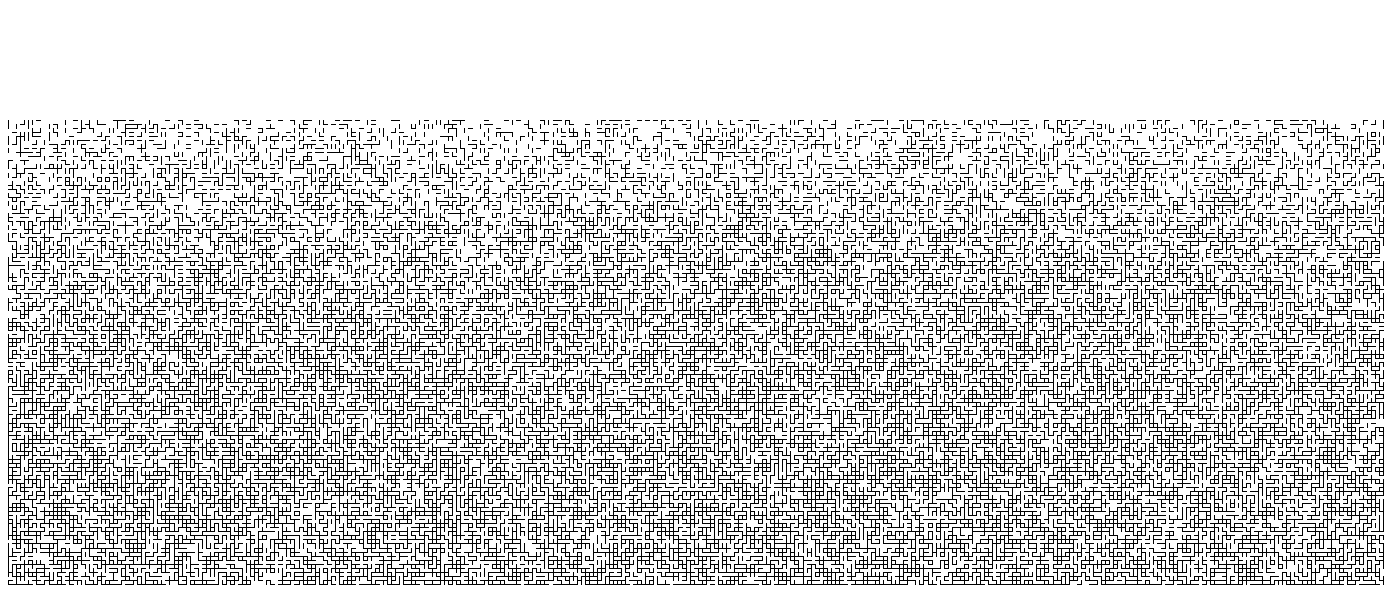

In [24]:
fig = plt.figure(figsize=(e.macro_params.cols * image_scale, e.macro_params.rows * image_scale), dpi=72)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()
vmin = 0
vmax = e.macro_params.cols - 1

ydiff = e.macro_params.rows - e.macro_params.cols

ax.set_xlim(vmin - 0.25, vmax + 0.25)
ax.set_ylim(-vmax - ydiff - 0.25, -vmin + 0.25)
ax.set_aspect("equal")
fig.canvas.draw()

for k in range(e.macro_params.total_edges):
    i, j = edge_index[k]
    if j % 3 != 1:
        if deg[sim][frame][k] > tsave[sim][frame]:
            plt.plot(
                [x1_f[k], x2_f[k]],
                [-y1_f[k], -y2_f[k]],
                color="black",
                marker=None,
                linewidth=1,
            )
    # elif 0 < deg[sim][frame][k] <= tsave[sim][frame]:
    # plt.plot([x1_f[k], x2_f[k]], [-y1_f[k], -y2_f[k]], color="xkcd:light grey", marker=None, linewidth=1)
fig.savefig(
    os.path.join(
        e.os_path,
        f"{sim:02}",
        f"fiber_grid_plot_r{sim:02}_{degrade_percent_markers[2]:.2f}" + file_code[:-4] + ".png",
    ),
    bbox_inches="tight",
)

In [16]:
deg[sim][frame][0] == tsave[sim][0]

True

In [14]:
tsave[sim][0]

0.0

In [12]:
colormap_f(1.0)

(0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 1.0)

In [13]:
colormap_f(1.1)

(0.047058823529411764, 0.12941176470588237, 0.7686274509803922, 1.0)

In [18]:
colormap_f(1)

(0.047058823529411764, 0.12941176470588237, 0.7686274509803922, 1.0)